# Project

# Data

The dataset<sup><a name="note-cariboo" href="#cariboo">[7]</a></sup> is composed of 7 different subsets, we will be using 4 of the datasets. Since each feature resides in different sets. 

- `Appearances.csv`
    - Player ID, Game ID, Appearance ID, Competition ID, Player club ID, Assist, Minutes Played, Yellow cards, Red Cards
- `Clubs.csv `
    - Club ID, Name, Pretty_name, Domestic_competition_id, Total_market_value, Squad_size, Average_age, Foreigners_numbers, Foreigners_percentage, National_team_players, Stadium_name, Stadium_seats, Net_transfer_record, Coach_name, URL
- `Competitions.csv`
    - Competition_id, Name, type, country_id, country_name, domestic_league_code, confederation, URL.  
- `Games.csv` 
    - Game_id, Competition_code, Season, Round, Date, Home_club_id, Away_club_id, Home_club_goals, away_club_goals, Home_club_postions, Away_club_postion, Stadium, Attendance, Referee, URL 
- `Leagues.csv` 
    - League_id, name, Confederation
- `Player_valuations.csv` 
    - Player_id, Date, Market_value
- `Players.csv`
    - Player_id, Last_season, Current_club_id, Name, Pretty_name, country_of_birth, Country_of_citizenship, Date_of_birth, Position, Sub_position, Foot, Height_in_cm, Market_value_in_gbp, Highest_market_value_in_gbp, URL

- _What an observation consists of_: We are trying to use the variables we assume to be the most important and independent from each other. We decided on 
    - Club, Nationality, League, Appearances, Minutes, Goals, Assist, Age, Conduct, Media Presence, Years Played, Trophies, Experience, Position, Physicality, Potential. 
- _What some critical variables are, how they are represented_: We want variables which have the highest co-variance with each other. The metric should handle most features as unique features. 
- _Any special handling, transformations, cleaning, etc will be needed_: There will be club names, and probably inferences in our data. Such as Media Presence or Potential, these are metrics which can be objective to the person. How popular is the player that we are analyzing? 

We are still going to be in search of more databases that might have different descriptive data that we might like to see how organizations search for talent. We can use what they might describe as their most sought out characteristics. 

For Simplicity we can also assume that all players have no contracts for their evaluation and are based solely on performance and the other variables mentioned.

In [1]:
!{__import__('sys').executable} -m pip install --quiet pandas

In [2]:
import pandas as pd

data = {
    name: pd.read_csv(
        file, 
        engine = 'c',
        low_memory = True,
        memory_map = False, # set `False` to load into memory
        **kwargs
    ) for name, file, kwargs in [
        ('appearances', 'data/appearances.csv', {}),
        ('clubs', 'data/clubs.csv', {}),
        ('competitions', 'data/competitions.csv', {}),
        ('games', 'data/games.csv', {}),
        ('leagues', 'data/leagues.csv', {}),
        ('players', 'data/players.csv', {
            'parse_dates': ['date_of_birth'],
            'dtype': {
                'last_season': 'category',
                'country_of_birth': 'category',
                'country_of_citizenship': 'category',
                'position': 'category',
                'sub_position': 'category'
            }
        }),
        ('player_valuations', 'data/player_valuations.csv', {})
    ]
}

In [3]:
data['clubs'] = data['clubs'][['club_id', 'name']]
data['clubs'].rename(
    columns = {'name': 'club_name'},
    inplace = True
)
data['clubs'].set_index('club_id', inplace = True)

data['clubs']

,club_name
club_id,
1032,fc-reading
2323,orduspor
1387,acn-siena-1904
3592,kryvbas-kryvyi-rig
1071,wigan-athletic
...,...
1269,pec-zwolle
200,fc-utrecht
317,fc-twente-enschede


In [4]:
data['games'] = data['games'][['season', 'game_id']]
data['games'].set_index('game_id', inplace = True)

data['games']

,season
game_id,
2244388,2012
2219794,2011
2244389,2012
2271112,2012
2229332,2012
...,...
3646190,2021
3646188,2021
3655616,2021


In [5]:
data['appearances'] = data['appearances'].loc[
    :, ~data['appearances'].columns.isin([
        'appearance_id', 
        'competition_id', 
        'player_club_id'
    ])
]

data['appearances'] = data['appearances'].merge(
    data['games'], 
    on = 'game_id',
    copy = False
).groupby(['player_id', 'season']).sum()
data['appearances'].drop(columns = 'game_id', inplace = True)

data['appearances'].reset_index('season', inplace = True)

data['appearances']

,season,goals,assists,minutes_played,yellow_cards,red_cards
player_id,,,,,,
10,2014,16,9,2289,6,0
10,2015,8,7,1714,3,0
26,2014,0,0,2880,0,0
26,2015,0,0,1260,1,0
26,2016,0,0,1020,0,0
...,...,...,...,...,...,...
926954,2021,0,0,24,1,0
926987,2021,0,0,3,0,0
934034,2021,0,0,3,0,0


In [6]:
data['player_valuations']['season'] = \
    pd.DatetimeIndex(data['player_valuations']['date']).year
data['player_valuations'].drop(columns = ['date'])

data['player_valuations'] = data['player_valuations'].groupby(
    ['player_id', 'season']
).mean()
data['player_valuations'].reset_index('season', inplace = True)

data['player_valuations'].rename(
    columns = {'market_value_in_gbp': 'market_value'},
    inplace = True
)

data['player_valuations']

,season,market_value
player_id,,
10,2004,6300000.0
10,2005,10800000.0
10,2006,22500000.0
10,2007,20700000.0
10,2008,18000000.0
...,...,...
928831,2021,45000.0
928831,2022,45000.0
934034,2021,45000.0


In [7]:
data['players'] = data['players'].loc[
    :, ~data['players'].columns.isin([
        'last_season',
        'pretty_name',
        'market_value_in_gbp',
        'highest_market_value_in_gbp',
        'country_of_birth',
        'url', 
        'foot'
    ])
]
data['players'].rename(
    columns = {
        'height_in_cm': 'height',
        'current_club_id': 'club_id',
        'country_of_citizenship': 'nationality'
    },
    inplace = True
)

data['players']['age'] = (
    pd.to_datetime('now', utc = True) 
        - pd.to_datetime(data['players']['date_of_birth'], utc = True)
).astype('timedelta64[Y]')
data['players'].drop(
    columns = ['date_of_birth'],
    inplace = True
)

data['players'].set_index('player_id', inplace = True)

data['players']

,club_id,name,nationality,position,sub_position,height,age
player_id,,,,,,,
254016,855,arthur-delalande,France,Midfield,midfield - Central Midfield,186,30.0
51053,23,daniel-davari,Iran,Goalkeeper,Goalkeeper,192,34.0
31451,23,torsten-oehrl,Germany,Attack,attack - Centre-Forward,192,36.0
44622,3691,vladimir-kisenkov,Russia,Defender,Defender - Right-Back,182,40.0
30802,3302,oscar-diaz,Spain,Attack,attack - Centre-Forward,183,38.0
...,...,...,...,...,...,...,...
462285,200,fabian-de-keijzer,Netherlands,Goalkeeper,Goalkeeper,193,22.0
368612,3057,merveille-bokadi,DR Congo,Defender,Defender - Centre-Back,186,26.0
408574,383,joey-veerman,Netherlands,Midfield,midfield - Central Midfield,185,23.0


In [8]:
df = data['players'].merge(
    data['player_valuations'].merge(
        data['appearances'], 
        on = ['player_id', 'season'],
        copy = False
    ), 
    on = 'player_id',
    copy = False
).merge(
    data['clubs'], 
    on = 'club_id',
    copy = False
)
df.drop(columns = 'club_id', inplace = True)

df

,name,nationality,position,sub_position,height,age,season,market_value,goals,assists,minutes_played,yellow_cards,red_cards,club_name
0,artem-milevskyi,Ukraine,Attack,attack - Centre-Forward,189,37.0,2020,90000.0,0,2,618,3,0,gaziantepspor
1,lucas-ontivero,Argentina,Attack,attack - Right Winger,170,27.0,2014,1350000.0,0,0,45,0,0,gaziantepspor
2,gilles-binya,Cameroon,Defender,Defender - Centre-Back,176,37.0,2014,1620000.0,0,1,669,1,1,gaziantepspor
3,joao-vitor,Brazil,Midfield,midfield - Defensive Midfield,176,34.0,2014,900000.0,0,1,547,3,0,gaziantepspor
4,demba-camara,Guinea,Attack,attack - Centre-Forward,186,27.0,2014,202500.0,2,0,705,2,0,gaziantepspor
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51836,jonas-bager,Denmark,Defender,Defender - Centre-Back,182,25.0,2020,270000.0,0,1,90,0,0,royale-union-saint-gilloise
51837,jonas-bager,Denmark,Defender,Defender - Centre-Back,182,25.0,2021,540000.0,0,1,1538,1,2,royale-union-saint-gilloise
51838,senne-lynen,Belgium,Midfield,midfield - Central Midfield,185,23.0,2020,259000.0,0,0,64,0,0,royale-union-saint-gilloise
51839,senne-lynen,Belgium,Midfield,midfield - Central Midfield,185,23.0,2021,585000.0,1,3,443,0,0,royale-union-saint-gilloise


In [9]:
df.dtypes

name                object
nationality       category
position          category
sub_position      category
height               int64
age                float64
season               int64
market_value       float64
goals                int64
assists              int64
minutes_played       int64
yellow_cards         int64
red_cards            int64
club_name           object
dtype: object

In [10]:
df.describe()

,height,age,season,market_value,goals,assists,minutes_played,yellow_cards,red_cards
count,51841.000000,51832.000000,51841.000000,5.184100e+04,51841.000000,51841.000000,51841.000000,51841.000000,51841.000000
mean,180.774156,29.735916,2017.368897,3.569469e+06,1.911672,1.451573,1380.464690,2.952702,0.070562
std,17.814441,4.905582,2.314096,8.201849e+06,3.649821,2.380698,1054.435695,3.041267,0.269955
min,0.000000,16.000000,2013.000000,9.000000e+03,0.000000,0.000000,1.000000,0.000000,0.000000
25%,178.000000,26.000000,2015.000000,3.600000e+05,0.000000,0.000000,397.000000,0.000000,0.000000
50%,182.000000,30.000000,2017.000000,9.000000e+05,0.000000,0.000000,1256.000000,2.000000,0.000000
75%,187.000000,33.000000,2019.000000,3.000000e+06,2.000000,2.000000,2184.000000,5.000000,0.000000
max,206.000000,49.000000,2021.000000,1.800000e+08,61.000000,31.000000,5061.000000,23.000000,3.000000


In [20]:
#
df[df['name'] == 'lionel-messi']

,name,nationality,position,sub_position,height,age,season,market_value,goals,assists,minutes_played,yellow_cards,red_cards,club_name
30592,lionel-messi,Argentina,Attack,attack - Right Winger,169,34.0,2014,108000000.0,58,31,5061,6,0,fc-paris-saint-germain
30593,lionel-messi,Argentina,Attack,attack - Right Winger,169,34.0,2015,108000000.0,41,24,4229,5,0,fc-paris-saint-germain
30594,lionel-messi,Argentina,Attack,attack - Right Winger,169,34.0,2016,108000000.0,54,20,4452,9,0,fc-paris-saint-germain
30595,lionel-messi,Argentina,Attack,attack - Right Winger,169,34.0,2017,108000000.0,45,20,4468,7,0,fc-paris-saint-germain
30596,lionel-messi,Argentina,Attack,attack - Right Winger,169,34.0,2018,156000000.0,51,22,4024,3,0,fc-paris-saint-germain
30597,lionel-messi,Argentina,Attack,attack - Right Winger,169,34.0,2019,130500000.0,30,25,3631,7,0,fc-paris-saint-germain
30598,lionel-messi,Argentina,Attack,attack - Right Winger,169,34.0,2020,95400000.0,39,15,4373,6,1,fc-paris-saint-germain
30599,lionel-messi,Argentina,Attack,attack - Right Winger,169,34.0,2021,66000000.0,11,13,2692,1,0,fc-paris-saint-germain


# Evaluation Metrics

We will be using an OLS regression model and the evaluation techniques we are considering are RMSE and Euclidean distance.
A possible evaluation metric we will use is RMSE or Mean Absolute Value of Errors. It is derived by calculating the difference between the estimated and actual value, square those results, then calculate the mean of those results. The formula for RMSE is 

$$
    \text{RMSE} = \sqrt{\frac{\sum_{i = 1}^{N}\left(\text{Predicted}_{i} - \text{Actual}_{i}\right)^{2}}{N}}
$$

# Preliminary results

In [11]:
!{__import__('sys').executable} -m pip install --quiet statsmodels numpy seaborn

In [12]:
# OLS using statsmodels
import statsmodels.api as sm
import numpy as np

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [13]:
# feature selection
X = df[[
    'goals', 
    'assists', 
    'minutes_played', 
    'yellow_cards', 
    'red_cards', 
    'height'
]]
y = df['market_value']

X = sm.add_constant(X)

OLS_model = sm.OLS(y, X).fit()
OLS_model.summary()

# X coeffecients and constant terms for prediction/plot
params = OLS_model.params

print(OLS_model.summary())
print(params)

                            OLS Regression Results                            
Dep. Variable:           market_value   R-squared:                       0.220
Model:                            OLS   Adj. R-squared:                  0.220
Method:                 Least Squares   F-statistic:                     2437.
Date:                Tue, 07 Jun 2022   Prob (F-statistic):               0.00
Time:                        17:19:06   Log-Likelihood:            -8.9242e+05
No. Observations:               51841   AIC:                         1.785e+06
Df Residuals:                   51834   BIC:                         1.785e+06
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -1.382e+06   3.27e+05     -4.

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)


In [14]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']

import seaborn as sns

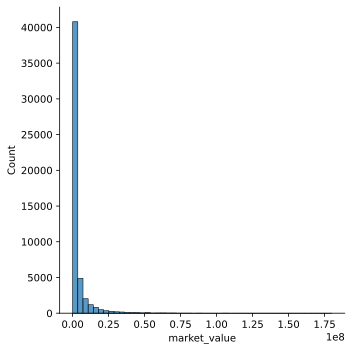

In [15]:
sns.displot(data = df, x = 'market_value', bins = 50)

plt.show()

In [16]:
df_highest_market_value_players = df.nlargest(n = 1, columns = 'market_value')

df_highest_market_value_players

,name,nationality,position,sub_position,height,age,season,market_value,goals,assists,minutes_played,yellow_cards,red_cards,club_name
30581,kylian-mbappe,France,Attack,attack - Centre-Forward,178,23.0,2019,180000000.0,24,12,2051,2,0,fc-paris-saint-germain


In [17]:
df_highest_market_value = df.loc[df['name'].isin(df_highest_market_value_players['name'])]

df_highest_market_value

,name,nationality,position,sub_position,height,age,season,market_value,goals,assists,minutes_played,yellow_cards,red_cards,club_name
30577,kylian-mbappe,France,Attack,attack - Centre-Forward,178,23.0,2015,45000.0,1,2,323,1,0,fc-paris-saint-germain
30578,kylian-mbappe,France,Attack,attack - Centre-Forward,178,23.0,2016,1518750.0,21,8,2108,2,0,fc-paris-saint-germain
30579,kylian-mbappe,France,Attack,attack - Centre-Forward,178,23.0,2017,40500000.0,17,10,2829,3,0,fc-paris-saint-germain
30580,kylian-mbappe,France,Attack,attack - Centre-Forward,178,23.0,2018,138600000.0,37,14,3030,7,1,fc-paris-saint-germain
30581,kylian-mbappe,France,Attack,attack - Centre-Forward,178,23.0,2019,180000000.0,24,12,2051,2,0,fc-paris-saint-germain
30582,kylian-mbappe,France,Attack,attack - Centre-Forward,178,23.0,2020,162000000.0,35,11,3583,6,0,fc-paris-saint-germain
30583,kylian-mbappe,France,Attack,attack - Centre-Forward,178,23.0,2021,144000000.0,31,25,3616,11,0,fc-paris-saint-germain


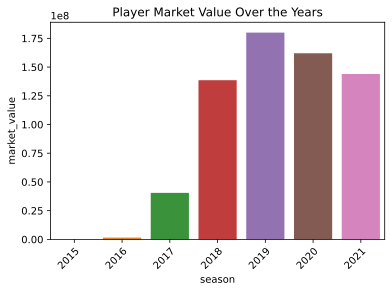

In [18]:
sns.barplot(data = df_highest_market_value, x = 'season', y = 'market_value')
plt.title('Player Market Value Over the Years')
plt.xticks(rotation = 45, ha = 'right', rotation_mode = 'anchor')

plt.show()

# Footnotes

<sup><a name="cariboo" href="#note-cariboo">7</a></sup> *Football Data from Transfermarkt.* (2022, April 22). [Dataset]. https://www.kaggle.com/datasets/davidcariboo/player-scores